In [34]:
from qiskit.circuit import QuantumRegister, Parameter
from qiskit import QuantumCircuit, Aer, execute
from qiskit.quantum_info import Operator, SparsePauliOp
from qiskit.primitives import Estimator
from qiskit_algorithms.gradients import ParamShiftEstimatorGradient
import numpy as np
from scipy.linalg import expm

In [35]:
simulator = Aer.get_backend('statevector_simulator')

In [36]:
theta_1, theta_2 = 0.2871, 1.6923

In [37]:
def U_1(theta: float):
    qc_1 = QuantumCircuit(1)
    qc_1.rx(theta=theta,qubit=0)
    return np.array(Operator(qc_1))

def U_2(theta: float):
    qc_2 = QuantumCircuit(1)
    qc_2.ry(theta=theta, qubit=0)
    return np.array(Operator(qc_2))

In [38]:
qc = QuantumCircuit(2)
qc.x(0)
qc.x(1)
XX = np.array(Operator(qc))
qc = QuantumCircuit(2)
qc.y(0)
qc.y(1)
YY = np.array(Operator(qc))


In [42]:
np.allclose(XX@YY - YY@XX, np.zeros_like(XX))

True

In [45]:
e_YY = expm(-1j*theta_1*YY)
np.allclose(XX@e_YY - e_YY@XX, np.zeros_like(XX))

True

In [48]:
YY_XX = YY+XX
e_YY_XX = expm(-1j/2*theta_1*YY_XX)
np.allclose(YY@e_YY_XX - e_YY_XX@YY, np.zeros_like(XX))

True

C:\Users\madse\.python_venvs\QiskitStuff\lib\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


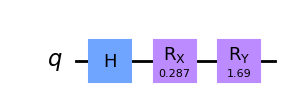

In [18]:
qc = QuantumCircuit(1)
result_0 = execute(qc, simulator).result()
psi_0 = np.array(result_0.get_statevector())

qc.h(qubit=0)
result_1 = execute(qc, simulator).result()
psi_1 = np.array(result_1.get_statevector())

qc.rx(theta=theta_1,qubit=0)
result_2 = execute(qc, simulator).result()
psi_2 = np.array(result_2.get_statevector())

qc.ry(theta=theta_2,qubit=0)
result_f = execute(qc, simulator).result()
psi_f = np.array(result_f.get_statevector())

qc.draw(output='mpl')

In [19]:
X_mat = np.array([[0,1],
                  [1,0]], dtype=np.complex128) 
Y_mat = np.array([[0,-1j],
                  [1j, 0]], dtype=np.complex128) 

In [20]:
O = 2*X_mat+Y_mat

In [21]:
# Parameter shift
deriv_theta_1 = 1/2*((psi_1.conj().T @ (U_1(theta_1 + np.pi/2).conj().T @ (O @ (U_1(theta_1 + np.pi/2) @ psi_1)))) - (psi_1.conj().T @ (U_1(theta_1 - np.pi/2).conj().T @ (O @ (U_1(theta_1 - np.pi/2) @ psi_1)))))

deriv_theta_2 = 1/2*((psi_2.conj().T @ (U_2(theta_2 + np.pi/2).conj().T @ (O @ (U_2(theta_2 + np.pi/2) @ psi_2)))) - (psi_2.conj().T @ (U_2(theta_2 - np.pi/2).conj().T @ (O @ (U_2(theta_2 - np.pi/2) @ psi_2)))))
my_derivs = np.array([deriv_theta_1, deriv_theta_2])

In [22]:
#Instantiate the quantum circuit
a = Parameter('a')
b = Parameter('b')
q = QuantumRegister(1)
qc = QuantumCircuit(q)
qc.h(q)
qc.rx(a, q[0])
qc.ry(b, q[0])

#Instantiate the Hamiltonian observable 2X+Y
H = SparsePauliOp.from_list([('X', 2), ('Y',1)])

#Parameter list
params = [[theta_1, theta_2]]

In [23]:
#Define the estimator
estimator = Estimator()
#Define the gradient
gradient = ParamShiftEstimatorGradient(estimator)

# Evaluate the gradient of the circuits using parameter shift gradients
pse_grad_result = gradient.run(qc, H,  params).result().gradients


In [24]:
np.allclose(my_derivs,pse_grad_result)

True